### 원본 클래스별 분포 확인 및 클래스별 데이터 저장

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import cv2
import os
import json
import random
import albumentations as A
from tqdm import tqdm
import shutil

In [2]:
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [5]:
DATA_PATH = '...'
TRAIN_PATH = DATA_PATH + 'sample_train/images/'
TEST_PATH = DATA_PATH + 'test/'
LABELS_PATH = DATA_PATH + 'labels/train.json'
TRAIN_LABEL_PATH = DATA_PATH + 'labels/train_label.json'
VAL_LABEL_PATH = DATA_PATH + 'labels/val_label.json'
TRAIN_AUG_LABEL_PATH = DATA_PATH + 'aug_labels/train_aug_label.json'
VAL_AUG_LABEL_PATH = DATA_PATH + 'aug_labels/val_aug_label.json'

In [4]:
with open(LABELS_PATH, 'r') as f:
    lab = json.load(f)

In [40]:
img_id_dict = dict()

for val in lab['images']:
    img_id_dict[val['id']] = val['file_name']

img_id_dict[1]

'train_0.png'

1    2344
3    2132
2     651
7     586
0     180
5     159
6     148
4     101
Name: count, dtype: int64

<BarContainer object of 8 artists>

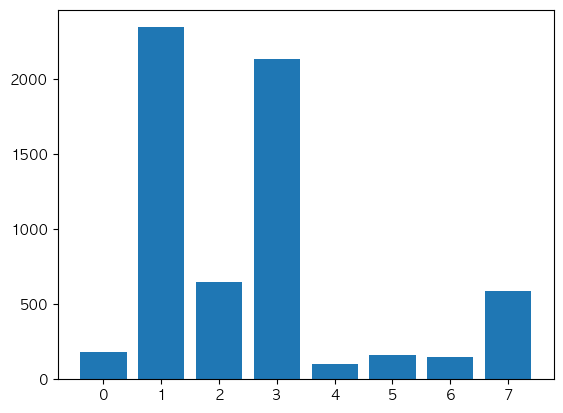

In [11]:
# 원본 데이터의 클래스 분포
cat_list = [x['category_id'] for x in lab['annotations']]
cat_col = pd.Series(cat_list).value_counts().sort_values(ascending=False)
display(cat_col)
plt.bar(cat_col.index, cat_col) # 베스랑 강준치를 숭어와 같이 한 500개 파일 정도로 줄이자.

In [66]:
# 베스랑 강준치 중에 한 이미지에 해당 객체가 많이 포함된 이미지는 꼭 챙겨가자.
bass = [x['image_id'] for x in lab['annotations'] if x['category_id'] == 1]
bass_col = pd.Series(bass).value_counts()
basses = bass_col[bass_col > 1].index.tolist()
bass_sample = []
for id in basses:
    bass_sample.append(img_id_dict[id])
print(len(bass_sample))
bass_sample[:5]

95


['train_17134.png',
 'train_17146.png',
 'train_71787.png',
 'train_64433.png',
 'train_76907.png']

In [67]:
# 베스 샘플링
random.seed(42)

bass_remain = list(set(bass) - set(basses))
print(len(bass_remain) == len(set(bass_remain))) # 중복 없음.
print(len(bass_remain))

bass_list = random.sample(bass_remain, 300)
bass_list = [img_id_dict[x] for x in bass_list]
bass_sample = bass_sample + bass_list # 랜덤 300개 + 베스 많은 파일. 이렇게하면 베스가 600개 정도됨.
print(bass_sample[-5:])
print(len(bass_sample))

True
2148
['train_75007.png', 'train_100886.png', 'train_55649.png', 'train_63564.png', 'train_61349.png']
395


In [68]:
# 강준치도 실행
random.seed(42)
gang = [x['image_id'] for x in lab['annotations'] if x['category_id'] == 3]
gang_col = pd.Series(gang).value_counts()
gangs = gang_col[gang_col > 1].index.tolist()
gang_sample = []
for id in gangs:
    gang_sample.append(img_id_dict[id])
print(len(gang_sample))
gang_sample[:5]

gang_remain = list(set(gang) - set(gangs))
print(len(gang_remain) == len(set(gang_remain))) # 중복 없음.
print(len(gang_remain))

gang_list = random.sample(gang_remain, 50)
gang_list = [img_id_dict[x] for x in gang_list]
gang_sample = gang_sample + gang_list # 랜덤 50개만. 강준치는 이미 2개 이상인 파일들 객체합치면 650개.
print(gang_sample[-5:])
print(len(gang_sample)) # 287개 파일이지만 객체는 700개 정도

237
True
1484
['train_41126.png', 'train_43245.png', 'train_27741.png', 'train_39579.png', 'train_14835.png']
287


In [69]:
file_id_dict = dict()

for val in lab['images']:
    file_id_dict[val['file_name']] = val['id']

file_id_dict['train_41126.png']

58594

In [237]:
# 베스랑 강준치는 샘플 파일에 해당하는
bass_ids = sorted([file_id_dict[x] for x in bass_sample])
gang_ids = sorted([file_id_dict[x] for x in gang_sample])
print(bass_ids[0])
len(bass_ids), len(gang_ids)

12220


(395, 287)

In [358]:
# 각 클래스마다 image_id 저장. 이미지당 여러 객체가 있을 수 있기때문에 id 중복 가능
class_0 = [x['image_id'] for x in lab['annotations'] if x['category_id'] == 0]
class_1 = [x['image_id'] for x in lab['annotations'] if x['image_id'] in bass_ids]
class_2 = [x['image_id'] for x in lab['annotations'] if x['category_id'] == 2]
class_3 = [x['image_id'] for x in lab['annotations'] if x['image_id'] in gang_ids]
class_4 = [x['image_id'] for x in lab['annotations'] if x['category_id'] == 4]
class_5 = [x['image_id'] for x in lab['annotations'] if x['category_id'] == 5]
class_6 = [x['image_id'] for x in lab['annotations'] if x['category_id'] == 6]
class_7 = [x['image_id'] for x in lab['annotations'] if x['category_id'] == 7]

In [360]:
# 각 클래스마다 bbox 저장
class_0_lab = [[x['bbox']] for x in lab['annotations'] if x['category_id'] == 0]
class_1_lab = [[x['bbox']] for x in lab['annotations'] if x['image_id'] in bass_ids]
class_2_lab = [[x['bbox']]for x in lab['annotations'] if x['category_id'] == 2]
class_3_lab = [[x['bbox']] for x in lab['annotations'] if x['image_id'] in gang_ids]
class_4_lab = [[x['bbox']] for x in lab['annotations'] if x['category_id'] == 4]
class_5_lab = [[x['bbox']] for x in lab['annotations'] if x['category_id'] == 5]
class_6_lab = [[x['bbox']] for x in lab['annotations'] if x['category_id'] == 6]
class_7_lab = [[x['bbox']] for x in lab['annotations'] if x['category_id'] == 7]

In [362]:
# class 마다 file 이름 저장
class_0_files = [img_id_dict[x] for x in class_0]
class_1_files = [img_id_dict[x] for x in class_1]
class_2_files = [img_id_dict[x] for x in class_2]
class_3_files = [img_id_dict[x] for x in class_3]
class_4_files = [img_id_dict[x] for x in class_4]
class_5_files = [img_id_dict[x] for x in class_5]
class_6_files = [img_id_dict[x] for x in class_6]
class_7_files = [img_id_dict[x] for x in class_7]

### Augmentation 수행
- 회색 변환
- HSV 변환
- 수평 변환
- 수직 변환
- Resize & Crop 변한
- 가우시안 노이즈 변환
- 밝기 대비 변환
- 선명도 변환
- 흐림도 변환

In [7]:
AUG_PATH = DATA_PATH + 'aug_images_eq/'
AUG_LABEL_PATH = DATA_PATH + 'aug_labels/'

In [52]:
# coco annotation 폼에 기반한 dictinary를 만드는 함수
def make_aug_label(cat_id, bbox, file_name):
    aug_dict = dict()
    aug_dict["id"] = 0
    aug_dict["image_id"] = 0
    aug_dict['file'] = file_name
    aug_dict['bbox'] = list(bbox)
    aug_dict["category_id"] = cat_id[0]
    aug_dict["segmentation"] = []
    aug_dict["area"] = bbox[2] * bbox[3]
    aug_dict["iscrowd"] = 0
    aug_dict["attributes"] = {
                "occluded": False,
                "rotation": 0.0
            }
    return aug_dict

# 회색 변환
def make_aug_gray(file_list, bbox_list, category_id):
    # 재현성을 위해 시드 고정
    np.random.seed(42)
    random.seed(42)

    # augmentation 적용
    transform = A.Compose([
        A.ToGray(p = 1.0)
    ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

    # augmentation이 적용된 라벨 데이터 만들기
    label_list = []
    for i in range(len(file_list)):
        img = cv2.imread(DATA_PATH + 'train/' + file_list[i])
        augmentation = transform(image=img, bboxes=bbox_list[i], category_ids=category_id)
        aug_img = augmentation['image']
        aug_bbox = augmentation['bboxes']
        file_name = file_list[i].split('.')[0] + '_aug_gray.png'
        aug_dict = make_aug_label(category_id, aug_bbox[0], file_name)
        label_list.append(aug_dict)
        cv2.imwrite(AUG_PATH + file_name, aug_img) # 라벨 생성
    return label_list # 생성된 coco 형식의 라벨 데이터 리턴

In [53]:
# hsv 변환
def make_aug_hsv(file_list, bbox_list, category_id):
    np.random.seed(42)
    random.seed(42)

    transform = A.Compose([
        A.ColorJitter (brightness=0.5, contrast=0.3, saturation=0.5, hue=0.02, always_apply=False, p=1.0),
    ],bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

    label_list = []
    for i in range(len(file_list)):
        img = cv2.imread(DATA_PATH + 'train/' + file_list[i])
        augmentation = transform(image=img, bboxes=bbox_list[i], category_ids=category_id)
        aug_img = augmentation['image']
        aug_bbox = augmentation['bboxes']
        file_name = file_list[i].split('.')[0] + '_aug_hsv.png'
        aug_dict = make_aug_label(category_id, aug_bbox[0], file_name)
        label_list.append(aug_dict)
        cv2.imwrite(AUG_PATH + file_name, aug_img)
    return label_list

In [54]:
# 수평 변환
def make_aug_horizon_flip(file_list, bbox_list, category_id):
    np.random.seed(42)
    random.seed(42)

    transform = A.Compose([
        A.HorizontalFlip(p=1.0),
    ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

    label_list = []
    for i in range(len(file_list)):
        img = cv2.imread(DATA_PATH + 'train/' + file_list[i])
        augmentation = transform(image=img, bboxes=bbox_list[i], category_ids=category_id)
        aug_img = augmentation['image']
        aug_bbox = augmentation['bboxes']
        file_name = file_list[i].split('.')[0] + '_aug_hflip.png'
        aug_dict = make_aug_label(category_id, aug_bbox[0], file_name)
        label_list.append(aug_dict)
        cv2.imwrite(AUG_PATH + file_name, aug_img)
    return label_list

In [55]:
# 리사이즈 & 크롭 변환
def make_aug_resize_and_crop(file_list, bbox_list, category_id):
    np.random.seed(42)
    random.seed(42)

    transform = A.Compose([
        A.Resize(height=640, width=720), # 원본보다 사이즈를 키워서 객체를 크게 한 다음 crop을 통해 다시 사이즈를 작게 만들 수 있음.
        A.RandomResizedCrop(height=640, width=720, scale=(0.8,1.0)),
    ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))


    label_list = []
    for i in range(len(file_list)):
        img = cv2.imread(DATA_PATH + 'train/' + file_list[i])
        augmentation = transform(image=img, bboxes=bbox_list[i], category_ids=category_id)
        aug_img = augmentation['image']
        aug_bbox = augmentation['bboxes']
        file_name = file_list[i].split('.')[0] + '_aug_resize_and_crop.png'
        aug_dict = make_aug_label(category_id, aug_bbox[0], file_name)
        label_list.append(aug_dict)
        cv2.imwrite(AUG_PATH + file_name, aug_img)
    return label_list

In [56]:
# 수직 변환
def make_aug_vertical_flip(file_list, bbox_list, category_id):
    np.random.seed(42)
    random.seed(42)

    transform = A.Compose([
        A.VerticalFlip(p=1.0),
    ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

    label_list = []
    for i in range(len(file_list)):
        img = cv2.imread(DATA_PATH + 'train/' + file_list[i])
        augmentation = transform(image=img, bboxes=bbox_list[i], category_ids=category_id)
        aug_img = augmentation['image']
        aug_bbox = augmentation['bboxes']
        file_name = file_list[i].split('.')[0] + '_aug_vflip.png'
        aug_dict = make_aug_label(category_id, aug_bbox[0], file_name)
        label_list.append(aug_dict)
        cv2.imwrite(AUG_PATH + file_name, aug_img)
    return label_list

In [57]:
# 밝기 대비
def make_aug_bright_contrast(file_list, bbox_list, category_id):
    np.random.seed(42)
    random.seed(42)

    transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), p=1),
    ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

    label_list = []
    for i in range(len(file_list)):
        img = cv2.imread(DATA_PATH + 'train/' + file_list[i])
        augmentation = transform(image=img, bboxes=bbox_list[i], category_ids=category_id)
        aug_img = augmentation['image']
        aug_bbox = augmentation['bboxes']
        file_name = file_list[i].split('.')[0] + '_aug_bc.png'
        aug_dict = make_aug_label(category_id, aug_bbox[0], file_name)
        label_list.append(aug_dict)
        cv2.imwrite(AUG_PATH + file_name, aug_img)
    return label_list

In [58]:
# 백색 소음
def make_aug_gauss(file_list, bbox_list, category_id):
    np.random.seed(42)
    random.seed(42)

    transform = A.Compose([
        A.GaussNoise(p=1, var_limit=(400, 500))
    ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

    label_list = []
    for i in range(len(file_list)):
        img = cv2.imread(DATA_PATH + 'train/' + file_list[i])
        augmentation = transform(image=img, bboxes=bbox_list[i], category_ids=category_id)
        aug_img = augmentation['image']
        aug_bbox = augmentation['bboxes']
        file_name = file_list[i].split('.')[0] + '_aug_gauss.png'
        aug_dict = make_aug_label(category_id, aug_bbox[0], file_name)
        label_list.append(aug_dict)
        cv2.imwrite(AUG_PATH + file_name, aug_img)
    return label_list

In [59]:
# 선명하게
def make_aug_clahe(file_list, bbox_list, category_id):
    np.random.seed(42)
    random.seed(42)

    transform = A.Compose([
        A.CLAHE(p=1)
    ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

    label_list = []
    for i in range(len(file_list)):
        img = cv2.imread(DATA_PATH + 'train/' + file_list[i])
        augmentation = transform(image=img, bboxes=bbox_list[i], category_ids=category_id)
        aug_img = augmentation['image']
        aug_bbox = augmentation['bboxes']
        file_name = file_list[i].split('.')[0] + '_aug_clahe.png'
        aug_dict = make_aug_label(category_id, aug_bbox[0], file_name)
        label_list.append(aug_dict)
        cv2.imwrite(AUG_PATH + file_name, aug_img)
    return label_list

In [60]:
# 흐릿하게
def make_aug_blur(file_list, bbox_list, category_id):
    np.random.seed(42)
    random.seed(42)

    transform = A.Compose([
        A.Blur(p=1, blur_limit=(5, 15))
    ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

    label_list = []
    for i in range(len(file_list)):
        img = cv2.imread(DATA_PATH + 'train/' + file_list[i])
        augmentation = transform(image=img, bboxes=bbox_list[i], category_ids=category_id)
        aug_img = augmentation['image']
        aug_bbox = augmentation['bboxes']
        file_name = file_list[i].split('.')[0] + '_aug_blur.png'
        aug_dict = make_aug_label(category_id, aug_bbox[0], file_name)
        label_list.append(aug_dict)
        cv2.imwrite(AUG_PATH + file_name, aug_img)
    return label_list

### 1. 농어-0 Augmentation

In [368]:
# 클래스별로 해당하는 데이터 augmentation
class_0_gray = make_aug_gray(class_0_files, class_0_lab, [0]) # 회색이미지
class_0_hsv = make_aug_hsv(class_0_files, class_0_lab, [0]) # hsv 변환
class_0_flip = make_aug_horizon_flip(class_0_files, class_0_lab, [0]) # flip
class_0_crop = make_aug_resize_and_crop(class_0_files, class_0_lab, [0]) # resize & crop
class_0_vflip = make_aug_vertical_flip(class_0_files, class_0_lab, [0]) # 수직 변환
class_0_bc = make_aug_bright_contrast(class_0_files, class_0_lab, [0]) # 밝기 대비
class_0_gauss = make_aug_gauss(class_0_files, class_0_lab, [0]) # 가우시안 노이즈
class_0_clahe = make_aug_clahe(class_0_files, class_0_lab, [0]) # 선명도
class_0_blur = make_aug_blur(class_0_files, class_0_lab, [0]) # 흐리게

# augmentation 결과 합치기
class_0_json = class_0_gray + class_0_hsv + class_0_flip + class_0_crop + class_0_vflip + class_0_bc + class_0_gauss + class_0_clahe + class_0_blur
print(len(class_0_json))
print(len(class_0_json) == (len(class_0_files) * 9))
class_0_json[:2]

1620
True


[{'id': 0,
  'image_id': 0,
  'file': 'train_9656_aug_gray.png',
  'bbox': [319.25, 235.21, 266.93000000000006, 113.34],
  'category_id': 0,
  'segmentation': [],
  'area': 30253.846200000007,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 0,
  'image_id': 0,
  'file': 'train_9657_aug_gray.png',
  'bbox': [307.37, 249.46, 325.5400000000001, 102.26000000000002],
  'category_id': 0,
  'segmentation': [],
  'area': 33289.72040000001,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

### 2. 베스-1 Augmentation

In [369]:
class_1_gray = make_aug_gray(class_1_files, class_1_lab, [1]) # 회색이미지
class_1_hsv = make_aug_hsv(class_1_files, class_1_lab, [1]) # hsv 변환
class_1_flip = make_aug_horizon_flip(class_1_files, class_1_lab, [1]) # flip
class_1_crop = make_aug_resize_and_crop(class_1_files, class_1_lab, [1]) # resize & crop
class_1_vflip = make_aug_vertical_flip(class_1_files, class_1_lab, [1]) # 수직 변환
class_1_bc = make_aug_bright_contrast(class_1_files, class_1_lab, [1]) # 밝기 대비
class_1_gauss = make_aug_gauss(class_1_files, class_1_lab, [1]) # 가우시안 노이즈
class_1_clahe = make_aug_clahe(class_1_files, class_1_lab, [1]) # 선명도
class_1_blur = make_aug_blur(class_1_files, class_1_lab, [1]) # 흐리게

class_1_json = class_1_gray + class_1_hsv + class_1_flip + class_1_crop + class_1_vflip + class_1_bc + \
    class_1_gauss + class_1_clahe + class_1_blur
print(len(class_1_json))
print(len(class_1_json) == (len(class_1_files) * 9))
class_1_json[:2]

4581
True


[{'id': 0,
  'image_id': 0,
  'file': 'train_8587_aug_gray.png',
  'bbox': [311.33, 293.03, 265.34, 65.82],
  'category_id': 1,
  'segmentation': [],
  'area': 17464.678799999998,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 0,
  'image_id': 0,
  'file': 'train_8606_aug_gray.png',
  'bbox': [114.02, 294.69, 221.07000000000005, 74.45999999999998],
  'category_id': 1,
  'segmentation': [],
  'area': 16460.872199999998,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

### 3. 숭어-2 Augmenttion

In [370]:
class_2_gray = make_aug_gray(class_2_files, class_2_lab, [2]) # 회색이미지
class_2_hsv = make_aug_hsv(class_2_files, class_2_lab, [2]) # hsv 변환
class_2_flip = make_aug_horizon_flip(class_2_files, class_2_lab, [2]) # flip
class_2_crop = make_aug_resize_and_crop(class_2_files, class_2_lab, [2]) # resize & crop
class_2_vflip = make_aug_vertical_flip(class_2_files, class_2_lab, [2]) # 수직 변환
class_2_bc = make_aug_bright_contrast(class_2_files, class_2_lab, [2]) # 밝기 대비
class_2_gauss = make_aug_gauss(class_2_files, class_2_lab, [2]) # 가우시안 노이즈
class_2_clahe = make_aug_clahe(class_2_files, class_2_lab, [2]) # 선명도
class_2_blur = make_aug_blur(class_2_files, class_2_lab, [2]) # 흐리게

class_2_json = class_2_gray + class_2_hsv + class_2_flip + class_2_crop + class_2_vflip + \
    class_2_bc + class_2_gauss + class_2_clahe + class_2_blur
print(len(class_2_json))
print(len(class_2_json) == (len(class_2_files) * 9))
class_2_json[:2]

5859
True


[{'id': 0,
  'image_id': 0,
  'file': 'train_326_aug_gray.png',
  'bbox': [14.45, 164.95, 171.09, 96.63],
  'category_id': 2,
  'segmentation': [],
  'area': 16532.4267,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 0,
  'image_id': 0,
  'file': 'train_405_aug_gray.png',
  'bbox': [15.09, 105.39, 438.0199999999999, 122.77],
  'category_id': 2,
  'segmentation': [],
  'area': 53775.71539999999,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

### 4. 강준치-3 Augmenttion

In [371]:
class_3_gray = make_aug_gray(class_3_files, class_3_lab, [3]) # 회색이미지
class_3_hsv = make_aug_hsv(class_3_files, class_3_lab, [3]) # hsv 변환
class_3_flip = make_aug_horizon_flip(class_3_files, class_3_lab, [3]) # flip
class_3_crop = make_aug_resize_and_crop(class_3_files, class_3_lab, [3]) # resize & crop
class_3_vflip = make_aug_vertical_flip(class_3_files, class_3_lab, [3]) # 수직 변환
class_3_bc = make_aug_bright_contrast(class_3_files, class_3_lab, [3]) # 밝기 대비
class_3_gauss = make_aug_gauss(class_3_files, class_3_lab, [3]) # 가우시안 노이즈
class_3_clahe = make_aug_clahe(class_3_files, class_3_lab, [3]) # 선명도
class_3_blur = make_aug_blur(class_3_files, class_3_lab, [3]) # 흐리게

class_3_json = class_3_gray + class_3_hsv + class_3_flip + class_3_crop + class_3_vflip + \
    class_3_bc + class_3_gauss + class_3_clahe + class_3_blur
print(len(class_3_json))
print(len(class_3_json) == (len(class_3_files) * 9))
class_3_json[:2]

6282
True


[{'id': 0,
  'image_id': 0,
  'file': 'train_295_aug_gray.png',
  'bbox': [247.17, 250.34, 278.81000000000006, 77.62000000000003],
  'category_id': 3,
  'segmentation': [],
  'area': 21641.232200000013,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 0,
  'image_id': 0,
  'file': 'train_925_aug_gray.png',
  'bbox': [11.129999999999999, 223.4, 419.77, 134.66],
  'category_id': 3,
  'segmentation': [],
  'area': 56526.2282,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

### 5. 블루길-4 Augmenttion

In [372]:
class_4_gray = make_aug_gray(class_4_files, class_4_lab, [4]) # 회색이미지
class_4_hsv = make_aug_hsv(class_4_files, class_4_lab, [4]) # hsv 변환
class_4_flip = make_aug_horizon_flip(class_4_files, class_4_lab, [4]) # flip
class_4_crop = make_aug_resize_and_crop(class_4_files, class_4_lab, [4]) # resize & crop
class_4_vflip = make_aug_vertical_flip(class_4_files, class_4_lab, [4]) # 수직 변환
class_4_bc = make_aug_bright_contrast(class_4_files, class_4_lab, [4]) # 밝기 대비
class_4_gauss = make_aug_gauss(class_4_files, class_4_lab, [4]) # 가우시안 노이즈
class_4_clahe = make_aug_clahe(class_4_files, class_4_lab, [4]) # 선명도
class_4_blur = make_aug_blur(class_4_files, class_4_lab, [4]) # 흐리게

class_4_json = class_4_gray + class_4_hsv + class_4_flip + class_4_crop + class_4_vflip + \
    class_4_bc + class_4_gauss + class_4_clahe + class_4_blur
print(len(class_4_json))
print(len(class_4_json) == (len(class_4_files) * 9))
class_4_json[:2]

909
True


[{'id': 0,
  'image_id': 0,
  'file': 'train_9934_aug_gray.png',
  'bbox': [114.26, 290.89, 115.64000000000003, 64.94999999999999],
  'category_id': 4,
  'segmentation': [],
  'area': 7510.818,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 0,
  'image_id': 0,
  'file': 'train_9935_aug_gray.png',
  'bbox': [110.93, 269.35, 148.12, 87.92000000000002],
  'category_id': 4,
  'segmentation': [],
  'area': 13022.710400000004,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

### 6. 잉어-5 Augmenttion

In [373]:
class_5_gray = make_aug_gray(class_5_files, class_5_lab, [5]) # 회색이미지
class_5_hsv = make_aug_hsv(class_5_files, class_5_lab, [5]) # hsv 변환
class_5_flip = make_aug_horizon_flip(class_5_files, class_5_lab, [5]) # flip
class_5_crop = make_aug_resize_and_crop(class_5_files, class_5_lab, [5]) # resize & crop
class_5_vflip = make_aug_vertical_flip(class_5_files, class_5_lab, [5]) # 수직 변환
class_5_bc = make_aug_bright_contrast(class_5_files, class_5_lab, [5]) # 밝기 대비
class_5_gauss = make_aug_gauss(class_5_files, class_5_lab, [5]) # 가우시안 노이즈
class_5_clahe = make_aug_clahe(class_5_files, class_5_lab, [5]) # 선명도
class_5_blur = make_aug_blur(class_5_files, class_5_lab, [5]) # 흐리게

class_5_json = class_5_gray + class_5_hsv + class_5_flip + class_5_crop + class_5_vflip + \
    class_5_bc + class_5_gauss + class_5_clahe + class_5_blur
print(len(class_5_json))
print(len(class_5_json) == (len(class_5_files) * 9))
class_5_json[:2]

1431
True


[{'id': 0,
  'image_id': 0,
  'file': 'train_185_aug_gray.png',
  'bbox': [57.07, 247.16999999999996, 384.16, 130.69000000000005],
  'category_id': 5,
  'segmentation': [],
  'area': 50205.87040000002,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 0,
  'image_id': 0,
  'file': 'train_186_aug_gray.png',
  'bbox': [96.59, 236.87, 427.01, 137.82],
  'category_id': 5,
  'segmentation': [],
  'area': 58850.5182,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

### 7. 붕어-6 Augmenttion

In [374]:
class_6_gray = make_aug_gray(class_6_files, class_6_lab, [6]) # 회색이미지
class_6_hsv = make_aug_hsv(class_6_files, class_6_lab, [6]) # hsv 변환
class_6_flip = make_aug_horizon_flip(class_6_files, class_6_lab, [6]) # flip
class_6_crop = make_aug_resize_and_crop(class_6_files, class_6_lab, [6]) # resize & crop
class_6_vflip = make_aug_vertical_flip(class_6_files, class_6_lab, [6]) # 수직 변환
class_6_bc = make_aug_bright_contrast(class_6_files, class_6_lab, [6]) # 밝기 대비
class_6_gauss = make_aug_gauss(class_6_files, class_6_lab, [6]) # 가우시안 노이즈
class_6_clahe = make_aug_clahe(class_6_files, class_6_lab, [6]) # 선명도
class_6_blur = make_aug_blur(class_6_files, class_6_lab, [6]) # 흐리게

class_6_json = class_6_gray + class_6_hsv + class_6_flip + class_6_crop + class_6_vflip + \
    class_6_bc + class_6_gauss + class_6_clahe + class_6_blur
print(len(class_6_json))
print(len(class_6_json) == (len(class_6_files) * 9))
class_6_json[:2]

1332
True


[{'id': 0,
  'image_id': 0,
  'file': 'train_11407_aug_gray.png',
  'bbox': [17.46, 242.41000000000003, 113.26999999999998, 78.41999999999996],
  'category_id': 6,
  'segmentation': [],
  'area': 8882.633399999993,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 0,
  'image_id': 0,
  'file': 'train_11408_aug_gray.png',
  'bbox': [26.89, 187.76, 225.82, 98.22000000000003],
  'category_id': 6,
  'segmentation': [],
  'area': 22180.040400000005,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

### 8. 누치-7 Augmenttion

In [375]:
class_7_gray = make_aug_gray(class_7_files, class_7_lab, [7]) # 회색이미지
class_7_hsv = make_aug_hsv(class_7_files, class_7_lab, [7]) # hsv 변환
class_7_flip = make_aug_horizon_flip(class_7_files, class_7_lab, [7]) # flip
class_7_crop = make_aug_resize_and_crop(class_7_files, class_7_lab, [7]) # resize & crop
class_7_vflip = make_aug_vertical_flip(class_7_files, class_7_lab, [7]) # 수직 변환
class_7_bc = make_aug_bright_contrast(class_7_files, class_7_lab, [7]) # 밝기 대비
class_7_gauss = make_aug_gauss(class_7_files, class_7_lab, [7]) # 가우시안 노이즈
class_7_clahe = make_aug_clahe(class_7_files, class_7_lab, [7]) # 선명도
class_7_blur = make_aug_blur(class_7_files, class_7_lab, [7]) # 흐리게

class_7_json = class_7_gray + class_7_hsv + class_7_flip + class_7_crop + class_7_vflip + \
    class_7_bc + class_7_gauss + class_7_clahe + class_7_blur
print(len(class_7_json))
print(len(class_7_json) == (len(class_7_files) * 9))
class_7_json[:2]

5274
True


[{'id': 0,
  'image_id': 0,
  'file': 'train_21212_aug_gray.png',
  'bbox': [282.66, 196.33, 227.92000000000002, 111.66],
  'category_id': 7,
  'segmentation': [],
  'area': 25449.5472,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 0,
  'image_id': 0,
  'file': 'train_21214_aug_gray.png',
  'bbox': [155.7, 177.8, 197.41000000000003, 127.82999999999998],
  'category_id': 7,
  'segmentation': [],
  'area': 25234.9203,
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

In [376]:
# augmentation이 적용된 모든 annotations 정보
aug_annot = class_0_json+class_1_json+class_2_json+class_3_json+class_4_json+class_5_json+class_6_json+class_7_json
len(aug_annot)

27288

### 이미지 확인

In [377]:
a = [x for x in os.listdir(AUG_PATH) if '18791' in x]
b = []
for x in a:
    for y in aug_annot:
        if y['file'] == x:
            b.append(y['bbox'])
    
print(a)

['train_18791_aug_blur.png', 'train_18791_aug_bc.png', 'train_18791_aug_gauss.png', 'train_18791_aug_gray.png', 'train_18791_aug_clahe.png', 'train_18791_aug_vflip.png', 'train_18791_aug_hsv.png', 'train_18791_aug_hflip.png', 'train_18791_aug_resize_and_crop.png']


In [378]:
def draw_aug_image(file, bbox):
    img = cv2.imread(AUG_PATH + file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x1 = int(bbox[0][0])
    y1 = int(bbox[0][1])
    w1 = int(bbox[0][2])
    h1 = int(bbox[0][3])

    x2 = int(bbox[1][0])
    y2 = int(bbox[1][1])
    w2 = int(bbox[1][2])
    h2 = int(bbox[1][3])

    x3 = int(bbox[2][0])
    y3 = int(bbox[2][1])
    w3 = int(bbox[2][2])
    h3 = int(bbox[2][3])

    x4 = int(bbox[3][0])
    y4 = int(bbox[3][1])
    w4 = int(bbox[3][2])
    h4 = int(bbox[3][3])

    cv2.rectangle(img, (x1,y1), (x1 + w1, y1 + h1), thickness=2, color=(0,255,255))
    cv2.rectangle(img, (x2,y2), (x2 + w2, y2 + h2), thickness=2, color=(0,255,0))
    cv2.rectangle(img, (x3,y3), (x3 + w3, y3 + h3), thickness=2, color=(255,0,255))
    cv2.rectangle(img, (x4,y4), (x4 + w4, y4 + h4), thickness=2, color=(123,115,5))

    print(file)
    print(img.shape)
    plt.imshow(img)
    plt.show()

train_18791_aug_blur.png
(480, 640, 3)


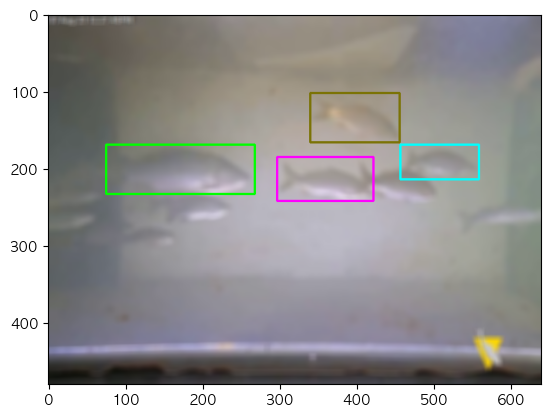

train_18791_aug_bc.png
(480, 640, 3)


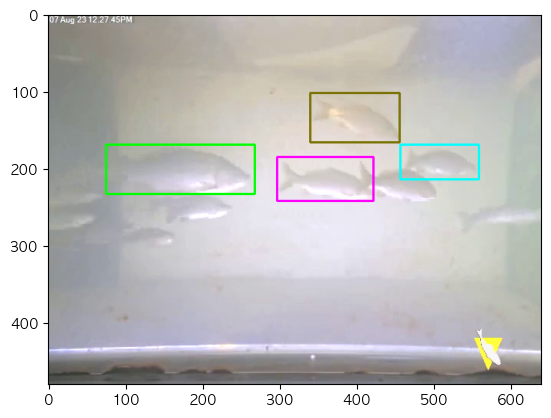

train_18791_aug_gauss.png
(480, 640, 3)


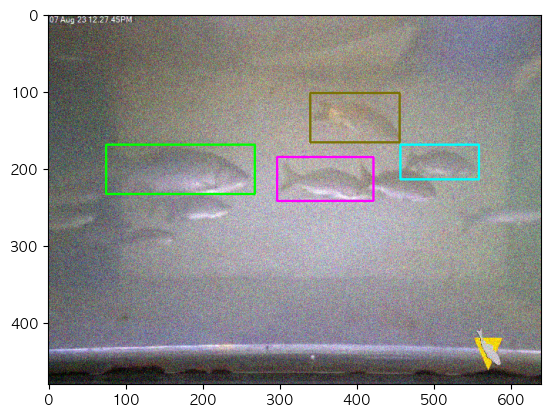

train_18791_aug_gray.png
(480, 640, 3)


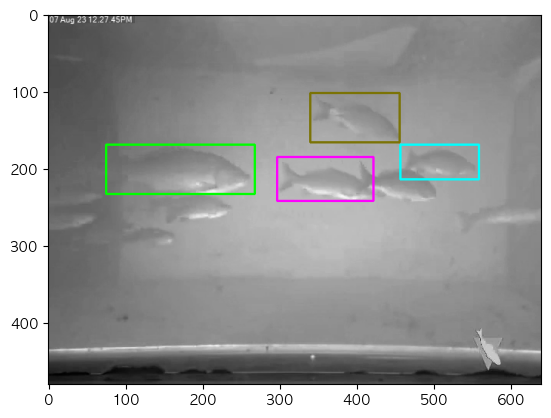

train_18791_aug_clahe.png
(480, 640, 3)


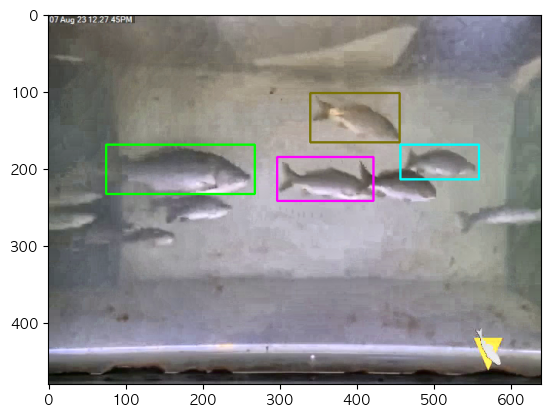

train_18791_aug_vflip.png
(480, 640, 3)


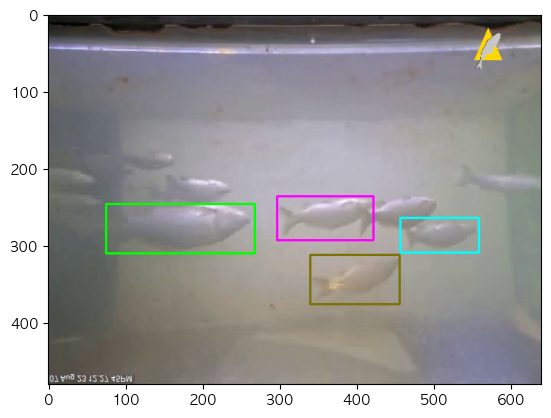

train_18791_aug_hsv.png
(480, 640, 3)


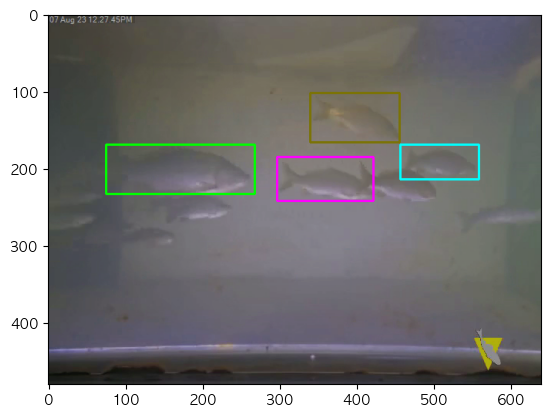

train_18791_aug_hflip.png
(480, 640, 3)


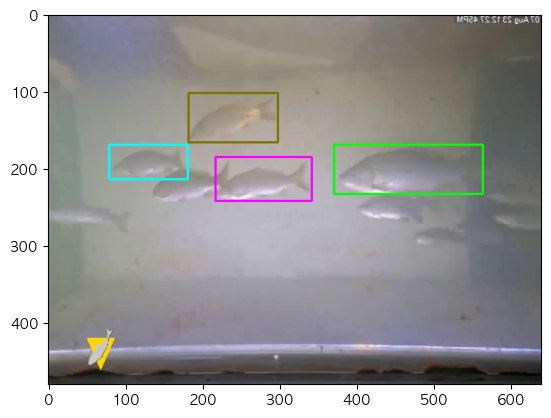

train_18791_aug_resize_and_crop.png
(640, 720, 3)


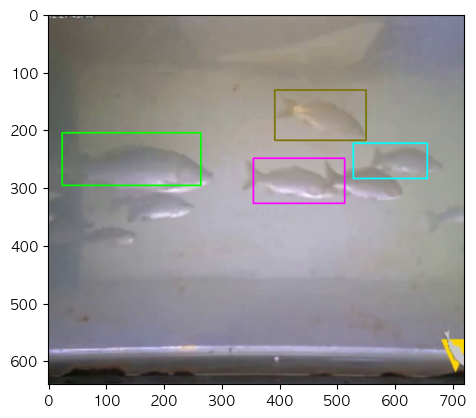

In [379]:
# 잘 매칭된 것 확인
draw_aug_image(a[0], b[:4])
draw_aug_image(a[1], b[4:8])
draw_aug_image(a[2], b[8:12])
draw_aug_image(a[3], b[12:16])
draw_aug_image(a[4], b[16:20])
draw_aug_image(a[5], b[20:24])
draw_aug_image(a[6], b[24:28])
draw_aug_image(a[7], b[28:32])
draw_aug_image(a[8], b[32:36])

### Train/Val 나누기

In [380]:
# 원본 파일들을 기준으로 나누기
df_nong = pd.DataFrame(list(set(class_0_files)), columns=['file'])
df_nong['category'] = 0
df_bass = pd.DataFrame(list(set(class_1_files)), columns=['file'])
df_bass['category'] = 1
df_soong = pd.DataFrame(list(set(class_2_files)), columns=['file'])
df_soong['category'] = 2
df_gang = pd.DataFrame(list(set(class_3_files)), columns=['file'])
df_gang['category'] = 3
df_blue = pd.DataFrame(list(set(class_4_files)), columns=['file'])
df_blue['category'] = 4
df_ing = pd.DataFrame(list(set(class_5_files)), columns=['file'])
df_ing['category'] = 5
df_boong = pd.DataFrame(list(set(class_6_files)), columns=['file'])
df_boong['category'] = 6
df_noo = pd.DataFrame(list(set(class_7_files)), columns=['file'])
df_noo['category'] = 7

df = pd.concat([df_nong, df_bass, df_soong, df_gang, df_blue, df_ing, df_boong, df_noo])
print(len(df))
display(df.head())
display(df.tail())

2354


file  category
0  train_98126.png         0
1  train_18513.png         0
2  train_69779.png         0
3  train_44387.png         0
4  train_21626.png         0

file  category
581  train_59315.png         7
582  train_53087.png         7
583  train_58634.png         7
584  train_54770.png         7
585  train_56953.png         7

In [381]:
df.category.value_counts() # augmentation이 원하던 비율대로 잘 적용됨

category
7    586
2    544
1    395
3    287
5    158
0    156
6    131
4     97
Name: count, dtype: int64

In [382]:
# train,val 재구축
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df.category)
display(train_df.head())
display(val_df.head())
print(train_df.shape, val_df.shape)

file  category
97    train_43741.png         5
43    train_18981.png         6
260   train_96595.png         7
270  train_103084.png         2
21    train_10756.png         0

file  category
339  train_44590.png         1
224  train_81432.png         1
491  train_68852.png         2
366  train_17209.png         2
454  train_17041.png         2

(2118, 2) (236, 2)


In [383]:
AUG_TRAIN_IMAGE_PATH = DATA_PATH + 'sample_aug_train_eq/images/'
AUG_VAL_IMAGE_PATH = DATA_PATH + 'sample_aug_val_eq/images/'

In [384]:
# 샘플로 뽑은 데이터 중 원본 데이터 옮기기
train_file_unique = list(set(train_df.file.tolist()))
val_file_unique = list(set(val_df.file.tolist()))
for file in os.listdir(DATA_PATH + 'train'):
    if file in train_file_unique:
        shutil.copy(DATA_PATH + 'train/' + file, AUG_TRAIN_IMAGE_PATH + file)
    elif file in val_file_unique:
        shutil.copy(DATA_PATH + 'train/' + file, AUG_VAL_IMAGE_PATH + file)

In [385]:
tr_org = [x.split('.')[0] for x in train_file_unique]
val_org = [x.split('.')[0] for x in val_file_unique]

# augmentation 파일을 학습, 검증으로 옮기기
for file in os.listdir(AUG_PATH):
    if file.split('_aug')[0] in tr_org:
        shutil.copy(AUG_PATH + file, AUG_TRAIN_IMAGE_PATH + file)
    elif file.split('_aug')[0] in val_org:
        shutil.copy(AUG_PATH + file, AUG_VAL_IMAGE_PATH + file)
    else:
        print(file)

In [386]:
len(os.listdir(AUG_TRAIN_IMAGE_PATH)), len(os.listdir(AUG_VAL_IMAGE_PATH)) # 객체가 다양해서 파일이 여러번 나올 수 있어서 train,val * 9개랑 갯수가 다를 수 있음

(21050, 2310)

### 배경 데이터 추가하기

In [387]:
back_id = list(set([x['image_id'] for x in lab['annotations']]))
back_files = []
for key, val in img_id_dict.items():
    if key not in back_id:
        back_files.append(val)
print(len(back_files))
back_files[:5] # train_1에 물고기 보이는데 잘려서 count 안 한 듯.

99314


['train_1.png', 'train_2.png', 'train_3.png', 'train_4.png', 'train_5.png']

In [388]:
# train에 배경 5000개 추가
random.seed(42)
back_img = sorted(random.sample(back_files, 5000))
print(back_img[:5])

for file in tqdm(back_img):
    shutil.copy(DATA_PATH + 'train/' + file, AUG_TRAIN_IMAGE_PATH + file)

['train_100008.png', 'train_100016.png', 'train_100060.png', 'train_100065.png', 'train_100073.png']


100%|██████████| 5000/5000 [00:05<00:00, 932.19it/s] 


In [389]:
# val에 배경 500개 추가
random.seed(42)
back_files2 = set(back_files) - set(back_img) # train과 겹치지않게
back_img_val = sorted(random.sample(back_files2, 500))
print(back_img_val[:5])

for file in tqdm(back_img_val):
    shutil.copy(DATA_PATH + 'train/' + file, AUG_VAL_IMAGE_PATH + file)

/var/folders/7d/_f3p3jgj74s_v7hf1tmxzxb40000gn/T/ipykernel_4260/3013821411.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  back_img_val = sorted(random.sample(back_files2, 500))


['train_100050.png', 'train_100108.png', 'train_100253.png', 'train_100303.png', 'train_10067.png']


100%|██████████| 500/500 [00:00<00:00, 1040.14it/s]


In [390]:
[x for x in back_files2 if x in back_img] # 학습과 검증 데이터 겹치는 배경 없음

[]

In [391]:
len(os.listdir(AUG_TRAIN_IMAGE_PATH)), len(os.listdir(AUG_VAL_IMAGE_PATH)) # 배경 추가완료

(26050, 2810)

### JSON 파일 만들기

In [392]:
# images key부터 만들기
train_json = dict()
train_json['images'] = []
for idx, file in enumerate(sorted(os.listdir(AUG_TRAIN_IMAGE_PATH))):
    if 'crop' in file:
        w, h = 720, 640
    else:
        w,h = 640, 480
    train_json['images'].append(
        {
            "id": idx,
            "width": w,
            "height": h,
            "file_name": file,
            "license": 0,
            "flickr_url": "",
            "coco_url": "",
            "date_captured": 0
        }
    )

In [393]:
print(len(train_json['images']))
display(train_json['images'][:2])

26050


[{'id': 0,
  'width': 640,
  'height': 480,
  'file_name': 'train_100008.png',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0},
 {'id': 1,
  'width': 640,
  'height': 480,
  'file_name': 'train_10001.png',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0}]

In [394]:
# images key부터 만들기
val_json = dict()
val_json['images'] = []
for idx, file in enumerate(sorted(os.listdir(AUG_VAL_IMAGE_PATH))):
    if 'crop' in file:
        w, h = 720, 640
    else:
        w,h = 640, 480
    val_json['images'].append(
        {
            "id": idx,
            "width": w,
            "height": h,
            "file_name": file,
            "license": 0,
            "flickr_url": "",
            "coco_url": "",
            "date_captured": 0
        }
    )

In [395]:
print(len(val_json['images']))
display(val_json['images'][:2])

2810


[{'id': 0,
  'width': 640,
  'height': 480,
  'file_name': 'train_100050.png',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0},
 {'id': 1,
  'width': 640,
  'height': 480,
  'file_name': 'train_100108.png',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0}]

In [396]:
# 새로운 id dict
tr_id_dict = dict()

for val in train_json['images']:
    tr_id_dict[val['file_name']] = val['id']

print(len(tr_id_dict))
print(list(tr_id_dict.keys())[:3])
print(list(tr_id_dict.values())[:3])

26050
['train_100008.png', 'train_10001.png', 'train_100016.png']
[0, 1, 2]


In [397]:
len(list(set(tr_id_dict.keys())))

26050

In [398]:
# 새로운 id dict
val_id_dict = dict()

for val in val_json['images']:
    val_id_dict[val['file_name']] = val['id']

print(len(val_id_dict))
print(list(val_id_dict.keys())[:3])
print(list(val_id_dict.values())[:3])

2810
['train_100050.png', 'train_100108.png', 'train_100253.png']
[0, 1, 2]


In [399]:
aug_annotation = sorted(aug_annot, key=lambda x: x['file'])
tr_aug_annot = []

idx = 0
for x in aug_annotation:
    if x['file'] in list(tr_id_dict.keys()):
        aug_dict = dict()
        aug_dict["id"] = idx
        aug_dict["image_id"] = tr_id_dict[x['file']]
        aug_dict["category_id"] = x['category_id']
        aug_dict["segmentation"] = []
        aug_dict["area"] = x['bbox'][2] * x['bbox'][3]
        aug_dict['bbox'] = x['bbox']
        aug_dict["iscrowd"] = 0
        aug_dict["attributes"] = {
                    "occluded": False,
                    "rotation": 0.0
                }
        tr_aug_annot.append(aug_dict)
        idx += 1
print(len(tr_aug_annot))
tr_aug_annot[:3]

24588


[{'id': 0,
  'image_id': 3,
  'category_id': 4,
  'segmentation': [],
  'area': 8123.511799999998,
  'bbox': [429.35, 299.37, 152.87, 53.139999999999986],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 1,
  'image_id': 4,
  'category_id': 4,
  'segmentation': [],
  'area': 8123.511799999998,
  'bbox': [429.35, 299.37, 152.87, 53.139999999999986],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 2,
  'image_id': 5,
  'category_id': 4,
  'segmentation': [],
  'area': 8123.511799999998,
  'bbox': [429.35, 299.37, 152.87, 53.139999999999986],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

In [401]:
val_aug_annot = []

idx = 0
for x in aug_annotation:
    if x['file'] in list(val_id_dict.keys()):
        aug_dict = dict()
        aug_dict["id"] = idx
        aug_dict["image_id"] = val_id_dict[x['file']]
        aug_dict["category_id"] = x['category_id']
        aug_dict["segmentation"] = []
        aug_dict["area"] = x['bbox'][2] * x['bbox'][3]
        aug_dict['bbox'] = x['bbox']
        aug_dict["iscrowd"] = 0
        aug_dict["attributes"] = {
                    "occluded": False,
                    "rotation": 0.0
                }
        val_aug_annot.append(aug_dict)
        idx += 1
print(len(val_aug_annot))
val_aug_annot[:3]

2700


[{'id': 0,
  'image_id': 6,
  'category_id': 1,
  'segmentation': [],
  'area': 13384.749300000001,
  'bbox': [405.11, 312.06, 168.51, 79.43],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 1,
  'image_id': 7,
  'category_id': 1,
  'segmentation': [],
  'area': 13384.749300000001,
  'bbox': [405.11, 312.06, 168.51, 79.43],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 2,
  'image_id': 8,
  'category_id': 1,
  'segmentation': [],
  'area': 13384.749300000001,
  'bbox': [405.11, 312.06, 168.51, 79.43],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

In [402]:
assert len(tr_aug_annot) + len(val_aug_annot) == len(aug_annot)

In [403]:
# annotations 생성
train_json['annotations'] = tr_aug_annot.copy()
val_json['annotations'] = val_aug_annot.copy()
train_json['categories'] = lab['categories']
val_json['categories'] = lab['categories']

In [404]:
with open(AUG_LABEL_PATH + 'train_aug_label_eq.json', 'w') as f:
    json.dump(train_json, f, ensure_ascii=False, indent=4)

with open(AUG_LABEL_PATH + 'val_aug_label_eq.json', 'w') as f:
    json.dump(val_json, f, ensure_ascii=False, indent=4)

In [9]:
with open(AUG_LABEL_PATH + 'train_aug_label_eq.json', 'r') as f:
    train_lab = json.load(f)

with open(AUG_LABEL_PATH + 'val_aug_label_eq.json', 'r') as f:
    val_lab = json.load(f)

print(len(train_lab['images']), len(train_lab['annotations']))

print(len(val_lab['images']), len(val_lab['annotations']))

26050 24588
2810 2700


### YOLO label txt 파일 만들기

In [2]:
%cd ..
%cd convert2Yolo

/Users/kimhyeonseung/Desktop/hs/project/fish
/Users/kimhyeonseung/Desktop/hs/project/fish/convert2Yolo


In [406]:
# 배경도 있기때문에 배경 파일은 생성되지 않음.
!python3 example.py --datasets COCO --img_path ../smaple_aug_train_eq/images --label ../aug_labels/train_aug_label_eq.json --convert_output_path ../sample_aug_train_eq/labels --img_type ".png" --manifest_path ./ --cls_list_file ./class.names


COCO Parsing:  |████████████████████████████████████████| 100.0% (24588/24588)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (18945/18945)  Complete---------------------------| 18.4% (3493/18945)  Complete35.3% (6693/18945)  Complete-------------| 46.3% (8774/18945)  Complete�██████████-----------------| 58.2% (11031/18945)  Complete��██████████████████████████------------| 72.2% (13684/18945)  Complete███████████████████-------| 84.5% (16014/18945)  Complete��██--| 96.6% (18308/18945)  Complete


YOLO Saving:   |████████████████████████████████████████| 100.0% (18945/18945)  Complete



In [3]:
# # 배경도 있기때문에 배경 파일은 생성되지 않음.
!python3 example.py --datasets COCO --img_path ../sample_aug_val_eq/images --label ../aug_labels/val_aug_label_eq.json --convert_output_path ../sample_aug_val_eq/labels --img_type ".png" --manifest_path ./ --cls_list_file ./class.names


COCO Parsing:  |████████████████████████████████████████| 100.0% (2700/2700)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (2079/2079)  Complete


YOLO Saving:   |████████████████████████████████████████| 100.0% (2079/2079)  Complete



In [408]:
label_test = train_lab['annotations'][0] # 10001bc
display(label_test)

# bbox도
x = label_test['bbox'][0]    # 좌측 최상단 x좌표
y = label_test['bbox'][1]    # 좌측 최상단 y좌표
w = label_test['bbox'][2]   # Box 가로
h = label_test['bbox'][3]   # Box 세로

image_width = 640
image_height = 480

x_center = round((x + w / 2) / image_width, 3)
y_center = round((y + h / 2) / image_height, 3)
bbox_width = round(w / image_width, 3)
bbox_height = round(h / image_height, 3)

print(x_center, y_center, bbox_width, bbox_height) # 잘 변환된 것을 확인할 수 있다.

{'id': 0,
 'image_id': 3,
 'category_id': 4,
 'segmentation': [],
 'area': 8123.511799999998,
 'bbox': [429.35, 299.37, 152.87, 53.139999999999986],
 'iscrowd': 0,
 'attributes': {'occluded': False, 'rotation': 0.0}}

0.79 0.679 0.239 0.111


In [409]:
AUG_TRAIN_PATH = DATA_PATH + 'sample_aug_train_eq/images/'
AUG_VAL_PATH = DATA_PATH + 'sample_aug_val_eq/images/'

In [422]:
# 각 augmentation 별로 랜덤하게 이미지 3개씩 확인
aug_gray = random.sample([x['file_name'] for x in train_lab['images'] if 'aug_gray' in x['file_name']], 3)
aug_hsv = random.sample([x['file_name'] for x in train_lab['images'] if 'aug_hsv' in x['file_name']], 3)
aug_flip = random.sample([x['file_name'] for x in train_lab['images'] if 'aug_hflip' in x['file_name']], 3)
aug_crop = random.sample([x['file_name'] for x in train_lab['images'] if 'aug_resize' in x['file_name']], 3)
aug_vflip = random.sample([x['file_name'] for x in train_lab['images'] if 'aug_vflip' in x['file_name']], 3)
aug_bc = random.sample([x['file_name'] for x in train_lab['images'] if 'aug_bc' in x['file_name']], 3)
aug_gauss = random.sample([x['file_name'] for x in train_lab['images'] if 'aug_gauss' in x['file_name']], 3)
aug_clahe = random.sample([x['file_name'] for x in train_lab['images'] if 'aug_clahe' in x['file_name']], 3)
aug_blur = random.sample([x['file_name'] for x in train_lab['images'] if 'aug_blur' in x['file_name']], 3)

In [423]:
def draw_aug_image(file, bbox):
    img = cv2.imread(AUG_TRAIN_PATH + file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    w1 = int(bbox[2])
    h1 = int(bbox[3])

    cv2.rectangle(img, (x1,y1), (x1 + w1, y1 + h1), thickness=2, color=(0,255,255))

    print(file)
    # print(bbox)
    print(img.shape)
    plt.imshow(img)
    plt.show()

train_59954_aug_gray.png
(480, 640, 3)


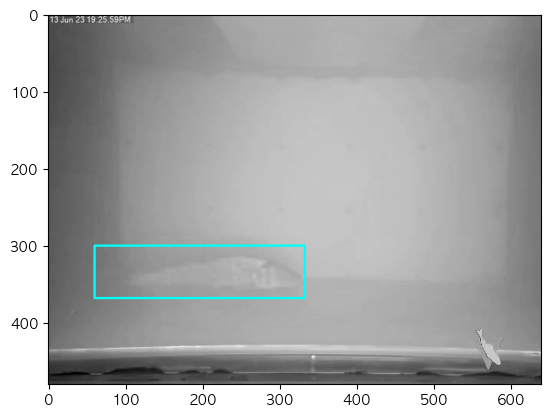

train_79598_aug_gray.png
(480, 640, 3)


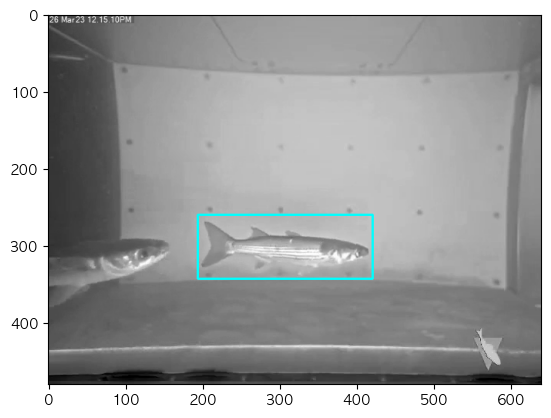

train_57789_aug_gray.png
(480, 640, 3)


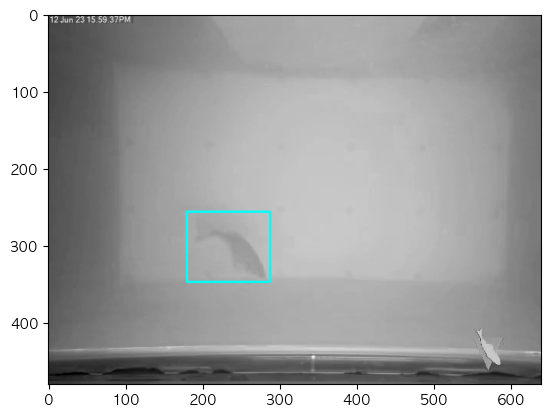

In [424]:
for file in aug_gray:
    bbox = [x['bbox'] for x in train_lab['annotations'] if tr_id_dict[file] == x['image_id']][0]
    draw_aug_image(file, bbox)

train_29650_aug_hsv.png
(480, 640, 3)


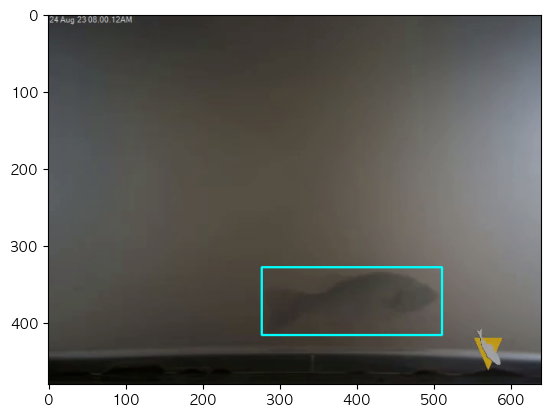

train_91338_aug_hsv.png
(480, 640, 3)


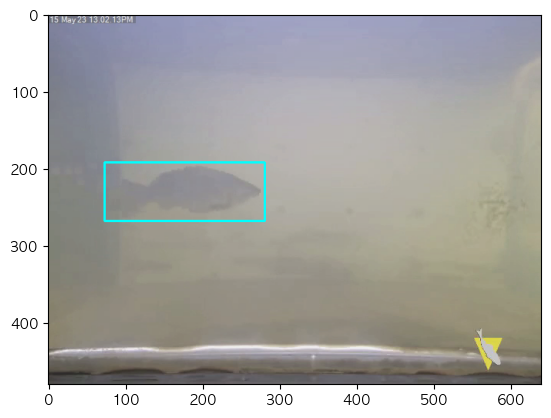

train_1257_aug_hsv.png
(480, 640, 3)


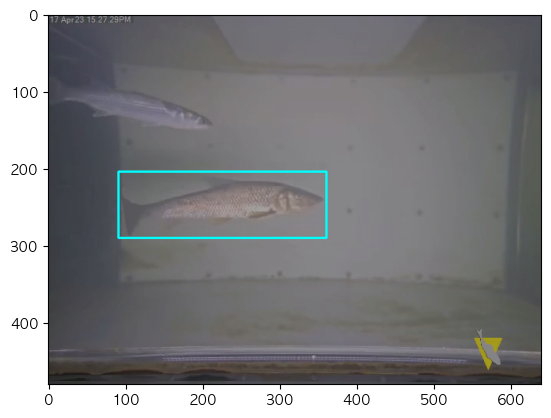

In [425]:
for file in aug_hsv:
    bbox = [x['bbox'] for x in train_lab['annotations'] if tr_id_dict[file] == x['image_id']][0]
    draw_aug_image(file, bbox)

train_17271_aug_hflip.png
(480, 640, 3)


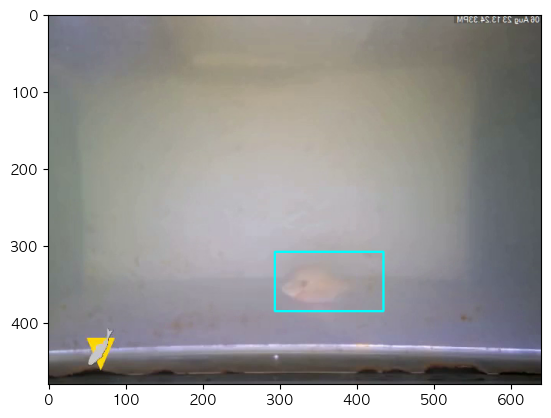

train_69468_aug_hflip.png
(480, 640, 3)


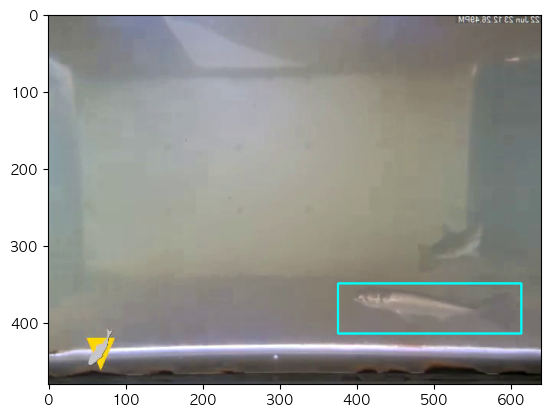

train_54963_aug_hflip.png
(480, 640, 3)


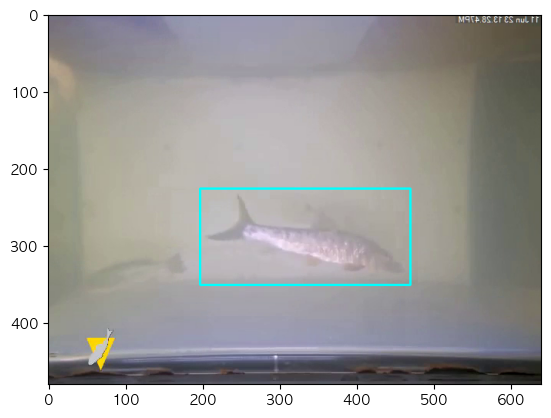

In [427]:
for file in aug_flip:
    bbox = [x['bbox'] for x in train_lab['annotations'] if tr_id_dict[file] == x['image_id']][0]
    draw_aug_image(file, bbox)

train_197_aug_resize_and_crop.png
(640, 720, 3)


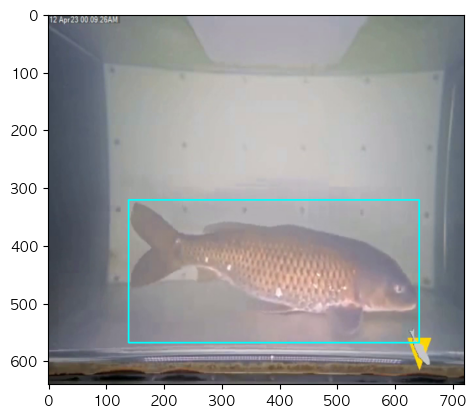

train_15907_aug_resize_and_crop.png
(640, 720, 3)


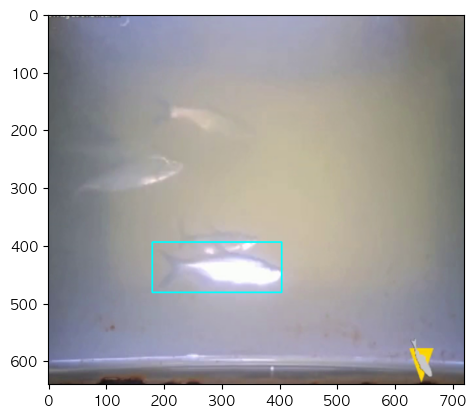

train_1450_aug_resize_and_crop.png
(640, 720, 3)


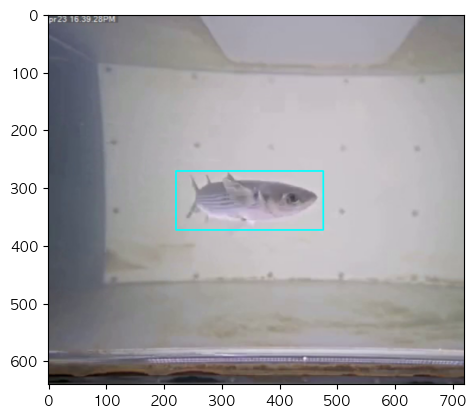

In [428]:
for file in aug_crop:
    bbox = [x['bbox'] for x in train_lab['annotations'] if tr_id_dict[file] == x['image_id']][0]
    draw_aug_image(file, bbox)

train_57248_aug_vflip.png
(480, 640, 3)


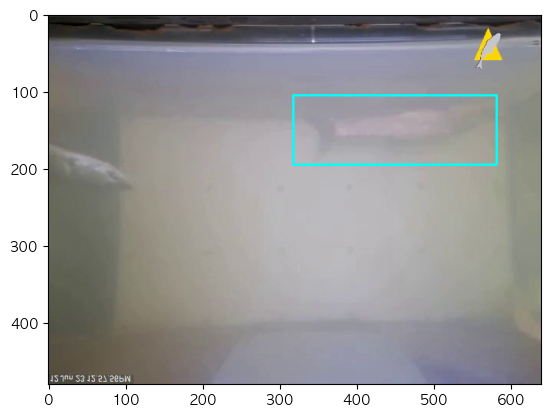

train_52576_aug_vflip.png
(480, 640, 3)


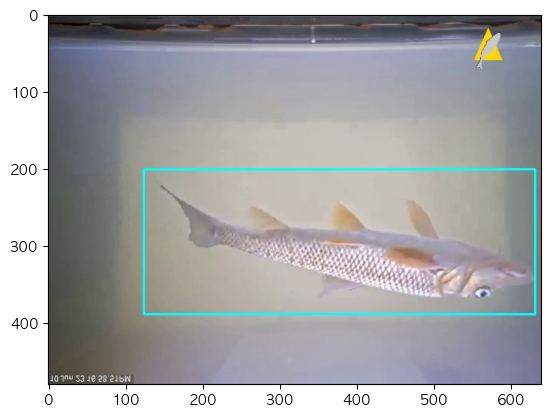

train_12959_aug_vflip.png
(480, 640, 3)


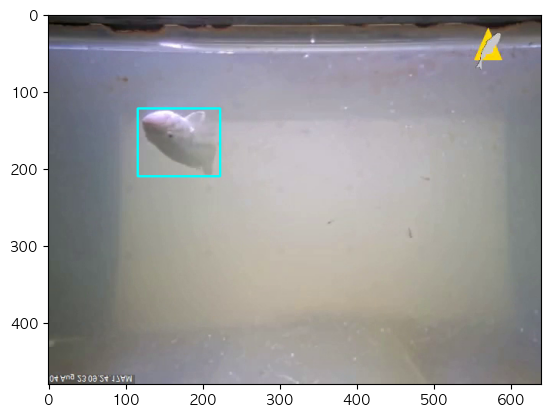

In [429]:
for file in aug_vflip:
    bbox = [x['bbox'] for x in train_lab['annotations'] if tr_id_dict[file] == x['image_id']][0]
    draw_aug_image(file, bbox)

train_46917_aug_bc.png
(480, 640, 3)


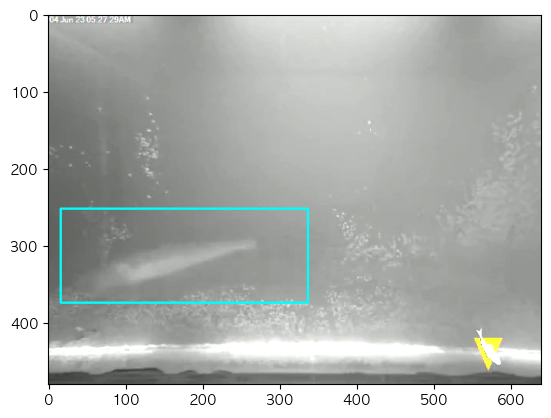

train_56681_aug_bc.png
(480, 640, 3)


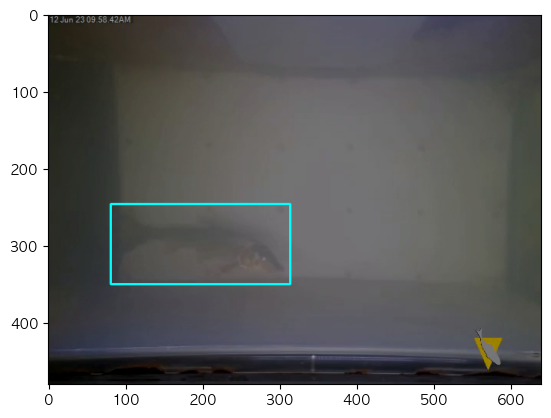

train_44241_aug_bc.png
(480, 640, 3)


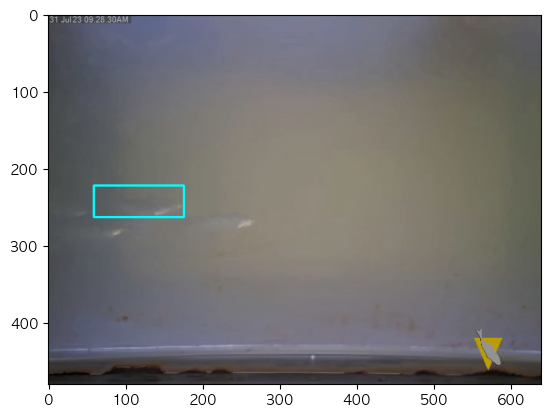

In [430]:
for file in aug_bc:
    bbox = [x['bbox'] for x in train_lab['annotations'] if tr_id_dict[file] == x['image_id']][0]
    draw_aug_image(file, bbox)

train_92082_aug_gauss.png
(480, 640, 3)


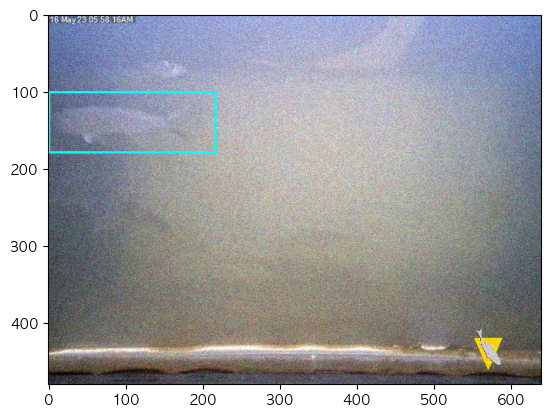

train_43684_aug_gauss.png
(480, 640, 3)


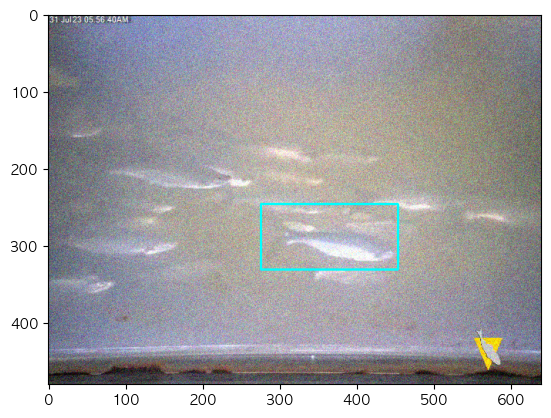

train_54529_aug_gauss.png
(480, 640, 3)


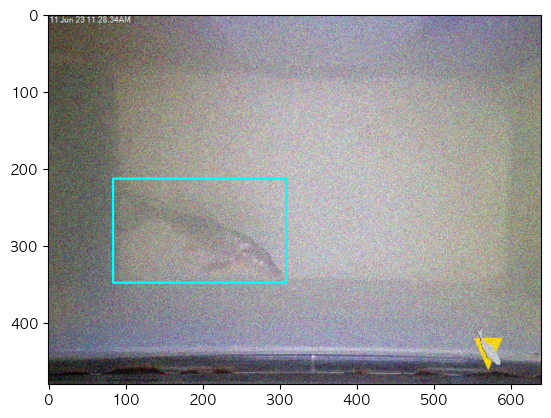

In [431]:
for file in aug_gauss:
    bbox = [x['bbox'] for x in train_lab['annotations'] if tr_id_dict[file] == x['image_id']][0]
    draw_aug_image(file, bbox)

train_89509_aug_clahe.png
(480, 640, 3)


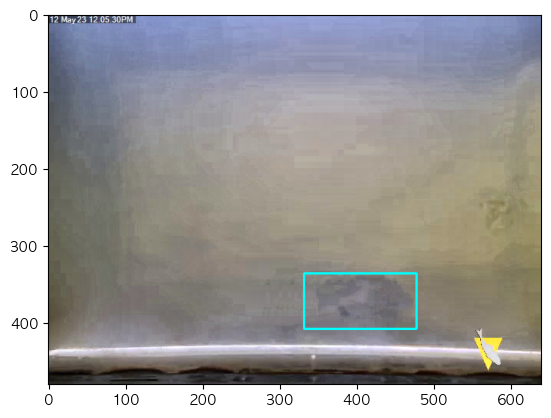

train_58072_aug_clahe.png
(480, 640, 3)


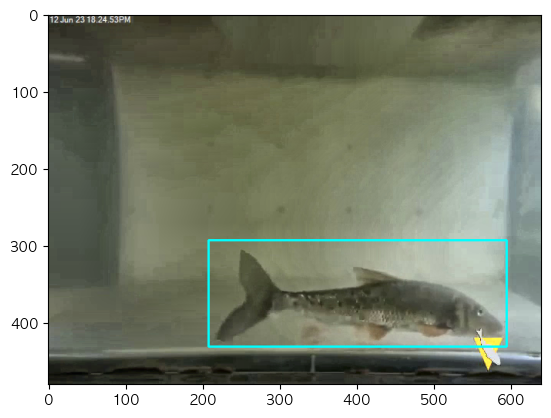

train_71890_aug_clahe.png
(480, 640, 3)


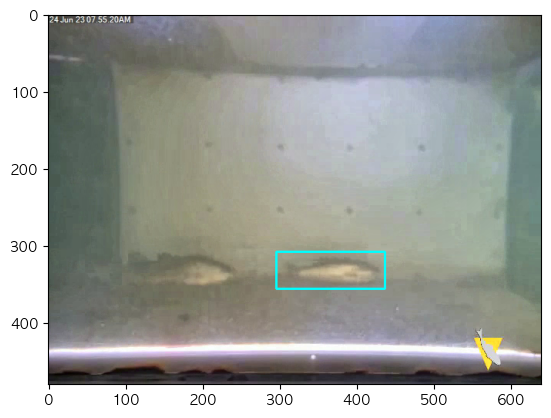

In [432]:
for file in aug_clahe:
    bbox = [x['bbox'] for x in train_lab['annotations'] if tr_id_dict[file] == x['image_id']][0]
    draw_aug_image(file, bbox)

train_48908_aug_blur.png
(480, 640, 3)


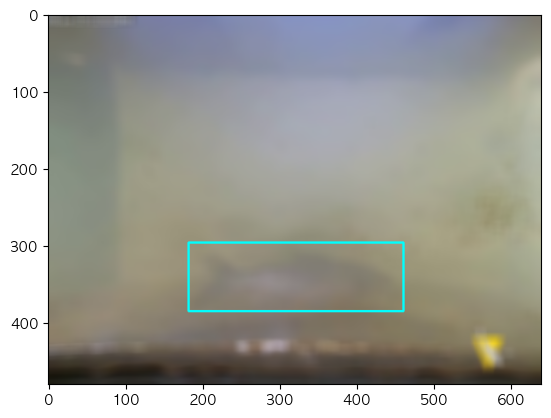

train_43685_aug_blur.png
(480, 640, 3)


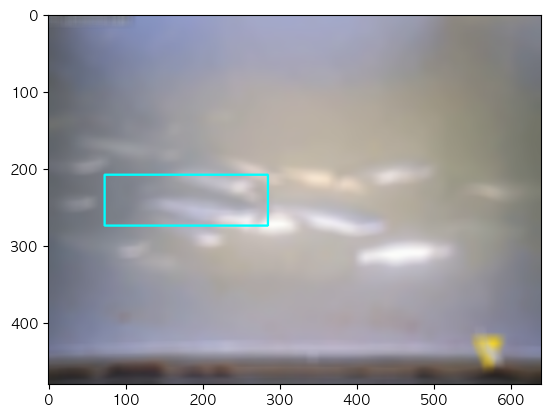

train_48287_aug_blur.png
(480, 640, 3)


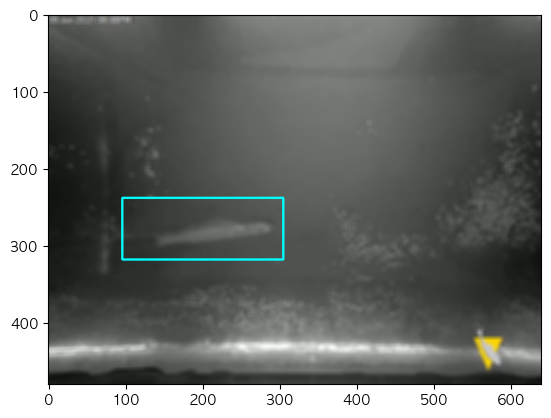

In [433]:
for file in aug_blur:
    bbox = [x['bbox'] for x in train_lab['annotations'] if tr_id_dict[file] == x['image_id']][0]
    draw_aug_image(file, bbox)

3    6282
2    5859
7    5274
1    4581
0    1620
5    1431
6    1332
4     909
Name: count, dtype: int64

<BarContainer object of 8 artists>

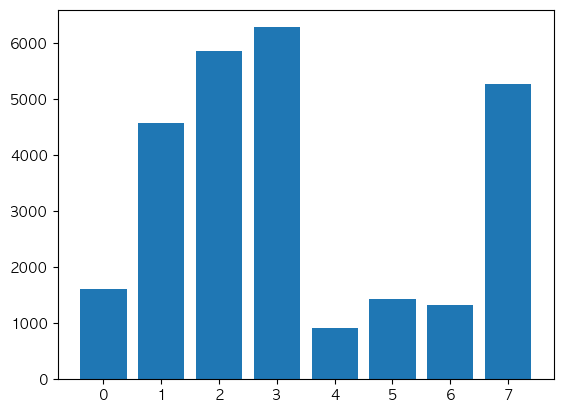

In [436]:
# 새로운 데이터셋의 클래스 분포 확인
tr_cat2 = [x['category_id'] for x in train_lab['annotations']]
val_cat2 = [x['category_id'] for x in val_lab['annotations']]

aug_cat2 = tr_cat2 + val_cat2
aug_df = pd.Series(aug_cat2).value_counts().sort_values(ascending=False)
tr_df = pd.Series(tr_cat2).value_counts().sort_values(ascending=False)
v_df = pd.Series(val_cat2).value_counts().sort_values(ascending=False)
display(aug_df)
plt.bar(aug_df.index, aug_df) # 베스, 숭어, 강준치 데이터가 매우 많지만 다른 데이터도 예측을 잘했던 블루길을 제외하고는 모두 천개이상.

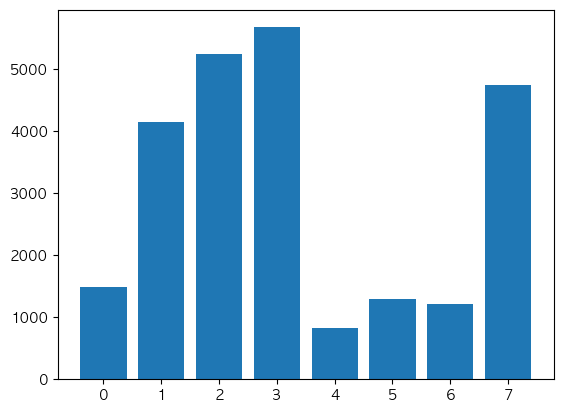

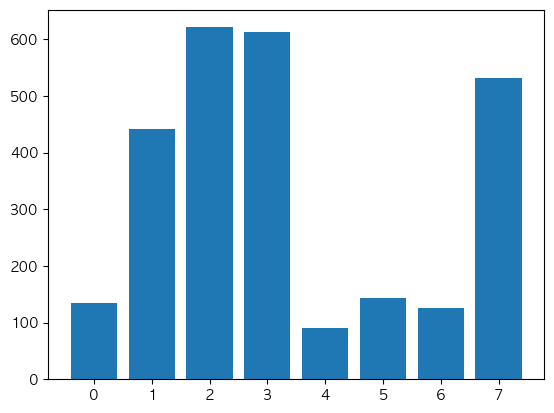

In [437]:
# 학습 검증 모두 비슷한 클래스 분포를 가지고 있음.
plt.bar(tr_df.index, tr_df)
plt.show()
plt.bar(v_df.index, v_df)
plt.show()